In [19]:
# global configuration variables
dbFilename = r"sound-palette-0.db"

# source folder for archive files
siblingSourceFolder = "corpus"

In [20]:
import essentia
from essentia import Pool, array
import essentia.streaming as ess
import essentia.standard as stan
from pylab import *
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Audio

## SQLite interface

In [21]:
import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
#     try:
    conn = sqlite3.connect(db_file)
    print(sqlite3.version)
    return conn
#     except Error as e:
#         print(e)
        
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def create_archive_file(conn, archive_file):
    """
    Create a new archive_file into the archive_file table
    :param conn:
    :param archive_file:
    :return: project id
    """
    sql = ''' INSERT INTO archive_files(name, durationSeconds)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, archive_file)
    conn.commit()
    return cur.lastrowid

def create_sound_object(conn, sound_object):
    """
    Create a new sound_object
    :param conn:
    :param sound_object:
    :return: sound_object id
    """

    sql = ''' INSERT INTO sound_objects(durationSeconds,effectiveDuration,rms,loudness,pitch,pitchConfidence,flatness,centroid,variance,path,archive_file_id,archive_file_duration_seconds,start,end)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, sound_object)
    conn.commit()

    return cur.lastrowid

def create_descriptor_stats(conn, stats):
    """
    Create a new task
    :param conn:
    :param stats:
    :return: stats id
    """

    sql = ''' INSERT INTO stats(descriptor, avg, stddev, min, max)
              VALUES(?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

    return cur.lastrowid

def update_stats(conn, stats):
    sql = ''' UPDATE stats
              SET descriptor = ?
              WHERE id = ?'''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

def delete_stats(conn):
    """
    Delete stats records
    :param conn:
    """

    sql = ''' DELETE FROM stats '''
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()

## SQLite user-defined functions

In [22]:
import sqlite3
import math

def create_stats(descriptorName,avg,stddev,descriptorMin,descriptorMax):
    statsRecord = (
        descriptorName,
        avg,
        stddev,
        descriptorMin,
        descriptorMax
    )
    return create_descriptor_stats(db, statsRecord)

# https://www.alexforencich.com/wiki/en/scripts/python/stdev
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
    
class HistogramFunc:
    def __init__(self):
        self.d = np.empty(1)

    def step(self, value):
        self.d = np.append(self.d, value)
 
    def finalize(self):
        self.d = np.delete(self.d, 0)
        
        stddev = np.std(self.d)
        mean = np.mean(self.d)
        descMin = np.amin(self.d)
        descMax = np.amax(self.d)

        print("mean, std")
        print(mean)
        print(stddev)
        
        print("min")
        print(descMin)
        print(np.argmin(self.d))

        
        print("max")
        print(descMax)
        print(np.argmax(self.d))

        range_low = mean - 2*stddev;
        range_high = mean + 2*stddev;
        if range_low < 0:
            range_low = 0
        range_tuple = (range_low,range_high)
        print(range_tuple)

        plt.hist(self.d, bins = 40, range = range_tuple) 
        plt.title("Histogram") 
        plt.show()
        
        stats_id = create_stats("name", mean, stddev, descMin, descMax)
        
        return stats_id


## Create database and tables

In [23]:
db = create_connection(dbFilename)

sql_create_stats_table = """ CREATE TABLE stats (
                                    id integer PRIMARY KEY,
                                    descriptor text NOT NULL,
                                    avg float NOT NULL,
                                    stddev float NOT NULL,
                                    min float NOT NULL,
                                    max float NOT NULL
                                ); """

sql_create_archive_files_table = """ CREATE TABLE archive_files (
                                    id integer PRIMARY KEY,
                                    name text NOT NULL,
                                    durationSeconds float NOT NULL
                                ); """

sql_create_sound_objects_table = """CREATE TABLE sound_objects (
                                    id integer PRIMARY KEY,
                                    durationSeconds float NOT NULL,
                                    effectiveDuration float NOT NULL,
                                    rms float NOT NULL,
                                    loudness float NOT NULL,
                                    pitch float NOT NULL,
                                    pitchConfidence float NOT NULL,
                                    flatness float NOT NULL,
                                    centroid float NOT NULL,
                                    variance float NOT NULL,
                                    path text NOT NULL,
                                    archive_file_id integer NOT NULL,
                                    archive_file_duration_seconds float NOT NULL,
                                    start integer NOT NULL,
                                    end integer NOT NULL,
                                    FOREIGN KEY (archive_file_id) REFERENCES archive_files (id)
                                );"""

# create tables
if db is not None:
    # create stats table
    create_table(db, sql_create_stats_table)
    
    # create archive_files table
    create_table(db, sql_create_archive_files_table)

    # create sound_objects table
    create_table(db, sql_create_sound_objects_table)
else:
    print("Error! cannot create the database connection.")

2.6.0
table stats already exists
table archive_files already exists
table sound_objects already exists


In [24]:
def get_sound_objects_from_onsets(onset_positions, audio):

    sound_objects = []
    skipped = 0
    numOnsets = onset_positions.shape[0]
    if numOnsets == 1:
        return sound_objects;
    for i in range(numOnsets):
        if i == 0:
            continue

        nStart = int(sampleRate * onset_positions[i-1]) # previous onset sample
        nEnd = int(sampleRate * onset_positions[i]) # current onset sample

        if(nEnd-nStart) < sampleRate*0.15: # remove sounds that are shorter than 0.15 seconds
            continue
        if(nEnd-nStart) > sampleRate*10: # filter sounds that are longer than 10
            continue

        startFrame = int(nStart/hopSize) # loss of precision here
        endFrame = int(nEnd/hopSize)

        sound_object_data = {}
        sound_object_data["rms"] = stan.Mean()(pool["features.rms"][startFrame:endFrame])
        
        sound_object_data["loudness"] = stan.Mean()(pool["features.loudness"][startFrame:endFrame])

        #print("mean rms: " + str(stan.Mean()(pool["features.rms"][startFrame:endFrame])))
        #print("weighted rms: " + str(sound_object_data["rms"]))
             
        sound_object_data["flatness"] = energy_weighted_mean(pool["features.flatnessDB"], startFrame, endFrame)
        
        weighted_mean_centroid = energy_weighted_mean(pool["features.centroid"], startFrame, endFrame)
        centroid_frequency = weighted_mean_centroid * (sampleRate/2)
        centroid_mel = 1000 * math.log2(1 + centroid_frequency/1000)
        sound_object_data["centroid"] = centroid_mel
        
        sound_object_data["variance"] = energy_weighted_mean(pool["features.variance"], startFrame, endFrame)

        pitch_freq = pitch_confidence_weighted_mean(pool["features.pitch"], startFrame, endFrame)
        if pitch_freq < 1:
            pitch_freq = 0
        sound_object_data["pitch"] = 1000 * math.log2(1 + pitch_freq/1000)
        #print("mean pitch: " + str(stan.Mean()(pool["features.pitch"][startFrame:endFrame])))
        #print("weighted pitch: " + str(sound_object_data["pitch"]))
        
        sound_object_data["pitchConfidence"] = energy_weighted_mean(pool["features.pitchConfidence"], startFrame, endFrame)
        
        sound_object_data["audio"] = audio[nStart:nEnd]
        sound_object_data["start"] = nStart
        sound_object_data["end"] = nEnd
        
        if(nStart > len(audio)):
            skipped = skipped + 1
            continue

        sound_objects.append(sound_object_data)

    return sound_objects

def energy_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.energy"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))

def pitch_confidence_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.pitchConfidence"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))
    

In [25]:
# putting it all together
from pathlib import Path
from scipy.io.wavfile import write, read
import json

def write_archive_file_sound_objects_to_db(archive_file_name, sound_objects, archive_file_duration_in_seconds):
    # initialize an object to store data for the clip
    archive_file = (archive_file_name, archive_file_duration_in_seconds,)
    archive_file_id = create_archive_file(db, archive_file)

    # process each detected sound_object
    for i, sound_object in enumerate(sound_objects):
        sourcePath = Path(f"{siblingSourceFolder}/{archive_file_name}")
        durationSeconds = len(sound_object["audio"]) / sampleRate
        
        effectiveDuration = stan.EffectiveDuration()(sound_object["audio"])
        
        sound_object_attributes = (
            durationSeconds,
            effectiveDuration,
            sound_object["rms"],
            sound_object["loudness"],
            sound_object["pitch"],
            sound_object["pitchConfidence"],
            sound_object["flatness"],
            sound_object["centroid"],
            sound_object["variance"],
            str("/".join(sourcePath.parts)),
            archive_file_id,
            archive_file_duration_in_seconds,
            sound_object["start"],
            sound_object["end"]
        )

        create_sound_object(db, sound_object_attributes)

In [26]:
def already_processed(archive_file_name):
    cursor = db.cursor()
    rowsQuery = "SELECT Count(*) FROM archive_files where name = '" + archive_file_name + "';"
    cursor.execute(rowsQuery)
    return cursor.fetchone()[0] > 0

In [27]:
from datetime import datetime
import os
print("Loading extractor...")

count = 1;

standardLoader = stan.MonoLoader()
streamingLoader = ess.MonoLoader()

sampleRate=44100
frameSize=2048
hopSize=512

framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
windowing = ess.Windowing(type='hann')
c2p = ess.CartesianToPolar()
od1 = ess.OnsetDetection(method='hfc')
fft = ess.FFT()
pitch = ess.PitchYinFFT(frameSize=frameSize)
rms = ess.RMS()
loudness = ess.Loudness()
flatness = ess.FlatnessDB()
centroid = ess.Centroid()
variance = ess.Variance()
spectrum = ess.Spectrum()
energy = ess.Energy()
pool = Pool()

# Connect streaming algorithms
streamingLoader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> fft.frame
fft.fft >> c2p.complex
c2p.phase >> od1.phase
c2p.magnitude >> None

windowing.frame >> energy.array
energy.energy >> (pool, 'features.energy')

windowing.frame >> spectrum.frame
spectrum.spectrum >> od1.spectrum
od1.onsetDetection >> (pool, 'features.hfc')

windowing.frame >> rms.array
rms.rms >> (pool, 'features.rms')

windowing.frame >> loudness.signal
loudness.loudness >> (pool, 'features.loudness')

spectrum.spectrum >> pitch.spectrum
pitch.pitch >> (pool, 'features.pitch')
pitch.pitchConfidence >> (pool, 'features.pitchConfidence')

c2p.magnitude >> flatness.array
flatness.flatnessDB >> (pool, 'features.flatnessDB')

c2p.magnitude >> centroid.array
centroid.centroid >> (pool, 'features.centroid')

c2p.magnitude >> variance.array
variance.variance >> (pool, 'features.variance')

for archive_file_name in os.listdir(os.getcwd() + "/" + siblingSourceFolder):
    if (archive_file_name.endswith(".wav") or archive_file_name.endswith(".m4a") or archive_file_name.endswith(".aiff") or archive_file_name.endswith(".mp3")):
        if already_processed(archive_file_name):
            print("skipping, we already processed: " + archive_file_name)
            continue
        standardLoader.configure(filename=siblingSourceFolder + "/" + archive_file_name)
        audio = standardLoader()
        streamingLoader.configure(filename=siblingSourceFolder + "/" + archive_file_name)
        
        essentia.run(streamingLoader)

        # Phase 2: compute the actual onsets locations
        
        # NOTE This implementation depends on a frameRate of 44100.0/512.0
        onsets = stan.Onsets(frameRate=sampleRate/hopSize)

        onsets_hfc = onsets(# this algo expects a matrix, not a vector
            array([ pool['features.hfc'] ]),
            # you need to specify weights, but as there is only a single
            # function, it doesn't actually matter which weight you give it
            [ 1 ])
        
        sound_objects = get_sound_objects_from_onsets(onsets_hfc, audio)
        
        archive_file_duration_in_seconds = len(audio)/sampleRate
        write_archive_file_sound_objects_to_db(archive_file_name, sound_objects, archive_file_duration_in_seconds)
        
        print('✅ ' + archive_file_name + " : " + str(len(sound_objects)) + " sound objects")

        count = count + 1
        # clear pool for next run
        pool.clear()



Loading extractor...
✅ Tapestries_01_wilderness-01.wav : 434 sound objects
✅ Tapestries_01_wilderness-02.wav : 266 sound objects
✅ Tapestries_01_wilderness-03.wav : 149 sound objects
✅ Tapestries_01_wilderness-04.wav : 209 sound objects
✅ Tapestries_01_wilderness-05.wav : 158 sound objects
✅ Tapestries_01_wilderness-06.wav : 274 sound objects
✅ Tapestries_01_wilderness-07.wav : 341 sound objects
✅ Tapestries_01_wilderness-08.wav : 345 sound objects
✅ Tapestries_01_wilderness-09.wav : 529 sound objects
✅ Tapestries_01_wilderness-10.wav : 457 sound objects
✅ Tapestries_01_wilderness-11.wav : 560 sound objects
✅ Tapestries_01_wilderness-12.wav : 384 sound objects
✅ Tapestries_01_wilderness-13.wav : 573 sound objects
✅ Tapestries_01_wilderness-14.wav : 385 sound objects
✅ Tapestries_01_wilderness-15.wav : 297 sound objects
✅ Tapestries_01_wilderness-16.wav : 243 sound objects
✅ Tapestries_01_wilderness-17.wav : 288 sound objects
✅ Tapestries_01_wilderness-18.wav : 91 sound objects
✅ Tapest

2.6.0
📊 durationSeconds 📈
mean, std
0.538963502114
0.820802712147
min
0.150907029478
152
max
9.70594104308
9733
(0, 2.1805689264092605)


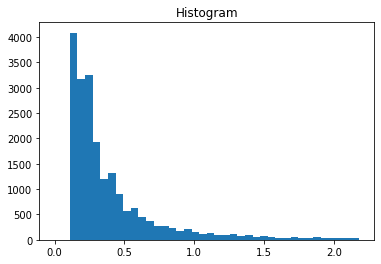

📊 effectiveDuration 📈
mean, std
0.0298793228492
0.0366761785896
min
2.26757365454e-05
935
max
0.777324259281
21270
(0, 0.10323168002841368)


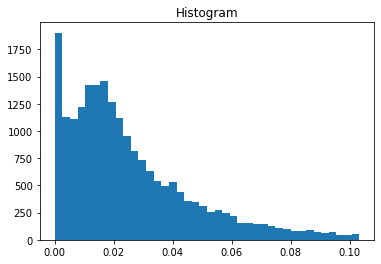

📊 rms 📈
mean, std
2.47120108539e-05
2.88295157141e-05
min
1.75562135496e-07
8308
max
0.000337670615409
8989
(0, 8.2371042282087175e-05)


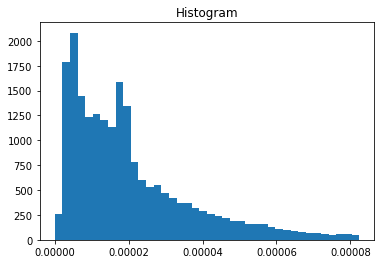

📊 loudness 📈
mean, std
0.000146155410166
0.000262530939481
min
1.56386974481e-07
8308
max
0.00377288064919
8989
(0, 0.00067121728912742881)


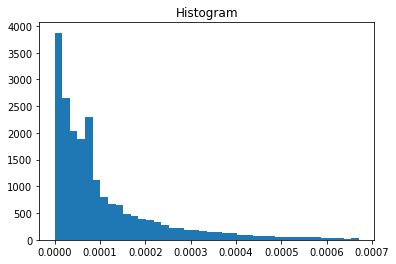

📊 pitch 📈
mean, std
1347.21964065
579.91658197
min
135.171591659
9313
max
3683.23479347
16564
(187.38647670523937, 2507.0528045848023)


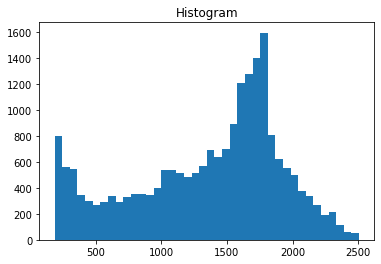

📊 flatness 📈
mean, std
0.124415540903
0.0640119012661
min
0.0204814858735
11460
max
0.336845189333
21140
(0, 0.25243934343515417)


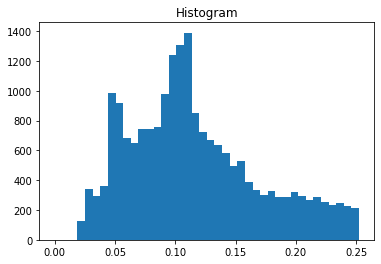

📊 centroid 📈
mean, std
2281.48083398
557.169395491
min
521.455340937
8748
max
3454.39742675
8308
(1167.1420429931688, 3395.8196249572666)


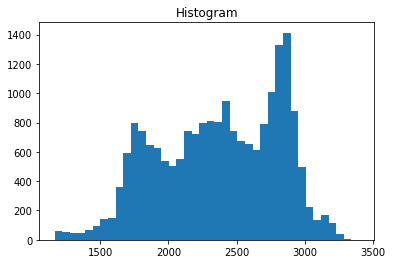

📊 variance 📈
mean, std
8.88587176888e-06
2.80467245875e-05
min
2.26138469062e-10
8308
max
0.000633967050817
8792
(0, 6.49793209438189e-05)


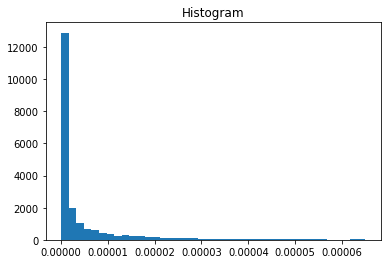

In [28]:
db = create_connection(dbFilename)
db.create_aggregate("stdev", 1, StdevFunc)
db.create_aggregate("histogram", 1, HistogramFunc)

 
def stats(column_name, conn):
    print("📊 %s 📈" % column_name)
    cur = db.cursor()
    cur.execute("select histogram(%s) from sound_objects" %column_name)
    stats_id = cur.fetchone()[0]
    stats_record = (column_name, stats_id)
    update_stats(conn, stats_record)
    
    
delete_stats(db)

stats("durationSeconds", db)
stats("effectiveDuration", db)
stats("rms", db)
stats("loudness", db)
stats("pitch", db)
stats("flatness", db)
stats("centroid", db)
stats("variance", db)
